<a href="https://colab.research.google.com/github/Yiting916/ML/blob/main/3-03.LAB_HR_%E8%A8%93%E7%B7%B4%E9%9A%8E%E6%AE%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 員工離職預測 分類問題

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/YiTing/Learning/Python/ML/R公司_人員資料_train.csv')
data.head()

,員工編號(EmployeeNumber),性別(Gender),年齡(Age),是否為成年人(Over18),婚姻狀態(MaritalStatus),通勤距離(DistanceFromHome),教育程度(Education),教育專業領域(EducationField),部門(Department),職位名稱(JobRole),...,股票選擇權等級(StockOptionLevel),績效評估(PerformanceRating),出差頻率(BusinessTravel),去年訓練時間(TrainingTimesLastYear),工作滿意度(JobSatisfaction),工作環境滿意度(EnvironmentSatisfaction),工作投入(JobInvolvement),工作生活平衡(WorkLifeBalance),人際關係滿意度(RelationshipSatisfaction),離職(Attrition)
0,1551,Male,24,Y,Divorced,21,2,Technical Degree,Research & Development,Laboratory Technician,...,3,3,Travel_Rarely,3,1,3,2,3,2,No
1,1012,Male,18,Y,Single,5,2,Life Sciences,Research & Development,Research Scientist,...,0,3,Non-Travel,2,4,2,3,3,4,No
2,349,Male,29,Y,Divorced,20,2,Marketing,Sales,Sales Executive,...,1,3,Travel_Rarely,2,4,4,3,3,4,No
3,1654,Male,39,Y,Married,12,3,Medical,Research & Development,Manufacturing Director,...,0,4,Travel_Rarely,3,2,4,3,3,3,No
4,1881,Male,31,Y,Divorced,20,3,Life Sciences,Research & Development,Laboratory Technician,...,1,3,Travel_Rarely,2,3,2,3,3,1,No


In [5]:
#列出欄位名稱
data.columns

Index(['員工編號(EmployeeNumber)', '性別(Gender)', '年齡(Age)', '是否為成年人(Over18)',
       '婚姻狀態(MaritalStatus)', '通勤距離(DistanceFromHome)', '教育程度(Education)',
       '教育專業領域(EducationField)', '部門(Department)', '職位名稱(JobRole)',
       '職位等級(JobLevel)', '在該公司工作總年資(YearsAtCompany)',
       '在該職位工作年資(YearsInCurrentRole)', '在該職等工作年資(YearsSinceLastPromotion)',
       '與現任管理者工作年資(YearsWithCurrManager)', '總工作年資(TotalWorkingYears)',
       '過去工作公司家數(NumCompaniesWorked)', '每日工資額(DailyRate)',
       '每小時工資額(HourlyRate)', '月收入(MonthlyIncome)', '月費率(MonthlyRate)',
       '標準工作時間(StandardHours)', '加班(OverTime)', '調薪百分比(PercentSalaryHike)',
       '股票選擇權等級(StockOptionLevel)', '績效評估(PerformanceRating)',
       '出差頻率(BusinessTravel)', '去年訓練時間(TrainingTimesLastYear)',
       '工作滿意度(JobSatisfaction)', '工作環境滿意度(EnvironmentSatisfaction)',
       '工作投入(JobInvolvement)', '工作生活平衡(WorkLifeBalance)',
       '人際關係滿意度(RelationshipSatisfaction)', '離職(Attrition)'],
      dtype='object')

In [6]:
# 刪除 離職 為空值的資料列
data = data.dropna(subset=['離職(Attrition)'])

# 自動前處理 (自製)

In [7]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                # self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [ ]:
# # AutoPreprocess Example
# ####################################################
# # Train Step
# mydata = pd.read_csv('../data/Automobile_Train.csv')
# ap = AutoPreprocess()
# ap.fit(mydata, ['symboling', 'Normalized-losses', 'make', 'Fuel-type', 'aspiration',
#        'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
#        'Wheel-base', 'length', 'width', 'height', 'Curb-weight', 'Engine-type',
#        'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'bore', 'stroke',
#        'Compression-ratio', 'horsepower', 'Peak-rpm', 'City-mpg',
#        'Highway-mpg'])
# ap.save("C:/DATA/test.bin")

# ####################################################
# # Test and inference
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# d2 = ap2.transform(mydata) #Pandas Dataframe
# d2.head()

# ####################################################
# # Test and inference with one record
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# data_dict = {"symboling":1, "aspiration":"std"}
# d2 = ap2.transform(data_dict) #Python Dict
# print(d2)


# 前處理

In [8]:
ap = AutoPreprocess()
ap.fit(data, ['員工編號(EmployeeNumber)', '性別(Gender)', '年齡(Age)', '是否為成年人(Over18)',
       '婚姻狀態(MaritalStatus)', '通勤距離(DistanceFromHome)', '教育程度(Education)',
       '教育專業領域(EducationField)', '部門(Department)', '職位名稱(JobRole)',
       '職位等級(JobLevel)', '在該公司工作總年資(YearsAtCompany)',
       '在該職位工作年資(YearsInCurrentRole)', '在該職等工作年資(YearsSinceLastPromotion)',
       '與現任管理者工作年資(YearsWithCurrManager)', '總工作年資(TotalWorkingYears)',
       '過去工作公司家數(NumCompaniesWorked)', '每日工資額(DailyRate)',
       '每小時工資額(HourlyRate)', '月收入(MonthlyIncome)', '月費率(MonthlyRate)',
       '標準工作時間(StandardHours)', '加班(OverTime)', '調薪百分比(PercentSalaryHike)',
       '股票選擇權等級(StockOptionLevel)', '績效評估(PerformanceRating)',
       '出差頻率(BusinessTravel)', '去年訓練時間(TrainingTimesLastYear)',
       '工作滿意度(JobSatisfaction)', '工作環境滿意度(EnvironmentSatisfaction)',
       '工作投入(JobInvolvement)', '工作生活平衡(WorkLifeBalance)',
       '人際關係滿意度(RelationshipSatisfaction)', '離職(Attrition)'])
ap.save("/content/drive/MyDrive/YiTing/Learning/Python/ML/preprocess_hr.bin")

X = ap.transform(data)
y = data['離職(Attrition)'].map({'Yes': 1, 'No': 0})

# 訓練模型 : 方法一

In [9]:
from sklearn.model_selection import train_test_split
# 分割資料成訓練組跟驗證組
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [ ]:
# 訓練模型
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(200,), max_iter=200, random_state=42)

# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor()

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()

model.fit(X_train, y_train)

RandomForestRegressor()

訓練組 R2: 0.9805269130042458
驗證組 R2: 0.9082761711093744


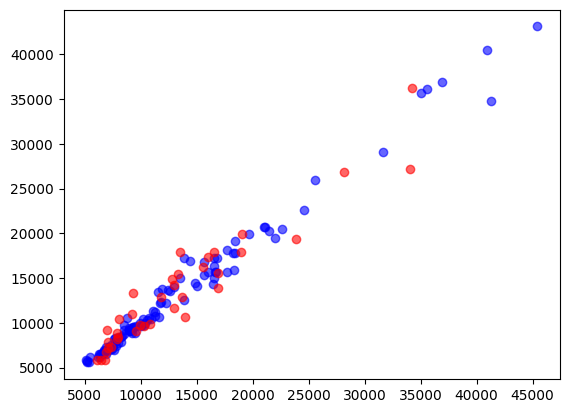

In [ ]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

y_pred = model.predict(X_train)
score = roc_auc_score(y_train, y_pred)
print("訓練組 AUC:", score)
score = recall_score(y_train, y_pred)
print("訓練組 Recall:", score)
score = precision_score(y_train, y_pred)
print("訓練組 Precision:", score)

# plt.scatter(y_train, y_pred, alpha=0.6, color='b')
# plt.show()

y_pred = model.predict(X_valid)
score = roc_auc_score(y_valid, y_pred)
print("驗證組 AUC:", score)
score = recall_score(y_valid, y_pred)
print("驗證組 Recall:", score)
score = precision_score(y_valid, y_pred)
print("驗證組 Precision:", score)

# plt.scatter(y_valid, y_pred, alpha=0.6, color='r')
# plt.show()


In [ ]:
#儲存模型
import pickle

with open("/content/drive/MyDrive/YiTing/Learning/Python/ML/model_hr.bin", "wb") as f:
    pickle.dump(model, f)


# RandomizedSearchCV版訓練 : 方法二

### SVR

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVR

param_grid = [
    {"kernel": ["linear"],"C":[0.1,1,10,100,100]},
    {"kernel": ["poly"], "degree": [2, 3],"C":[0.1,1,10,100,100],"gamma":["scale", "auto"]},
    {"kernel": ["rbf"],"C":[0.1,1,10,100,100],"gamma":["scale", "auto"]},
]

model = SVR()

search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring="r2")
search.fit(X, y)

RandomizedSearchCV(estimator=SVR(),
                   param_distributions=[{'C': [0.1, 1, 10, 100, 100],
                                         'kernel': ['linear']},
                                        {'C': [0.1, 1, 10, 100, 100],
                                         'degree': [2, 3],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['poly']},
                                        {'C': [0.1, 1, 10, 100, 100],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['rbf']}],
                   scoring='r2')

In [ ]:
search.best_params_

{'kernel': 'linear', 'C': 100}

In [ ]:
search.cv_results_

{'mean_fit_time': array([0.01504946, 0.00918946, 0.00937252, 0.00904646, 0.0049788 ,
        0.0113112 , 0.01115561, 0.00893159, 0.00594854, 0.00601859]),
 'std_fit_time': array([0.00084326, 0.0031329 , 0.00432742, 0.00257342, 0.00088564,
        0.00451558, 0.0013785 , 0.00277314, 0.00122239, 0.00102634]),
 'mean_score_time': array([0.00624466, 0.00437875, 0.00392957, 0.00381489, 0.00256376,
        0.00608315, 0.00473695, 0.00404387, 0.00327258, 0.0035646 ]),
 'std_score_time': array([0.00136981, 0.0013798 , 0.00094189, 0.00128145, 0.00101234,
        0.00051824, 0.00084577, 0.00114711, 0.00121451, 0.00070852]),
 'param_kernel': masked_array(data=['poly', 'poly', 'poly', 'linear', 'linear', 'rbf',
                    'linear', 'poly', 'poly', 'poly'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=['auto', 'scale', 'scale', --, --, 'aut

In [ ]:
search.best_estimator_

SVR(C=100, kernel='linear')

In [ ]:
#儲存模型
import pickle

with open("/content/drive/MyDrive/YiTing/Learning/Python/ML/model_hr.bin", "wb") as f:
    pickle.dump(search.best_estimator_, f)


R2: 0.8318754486337084


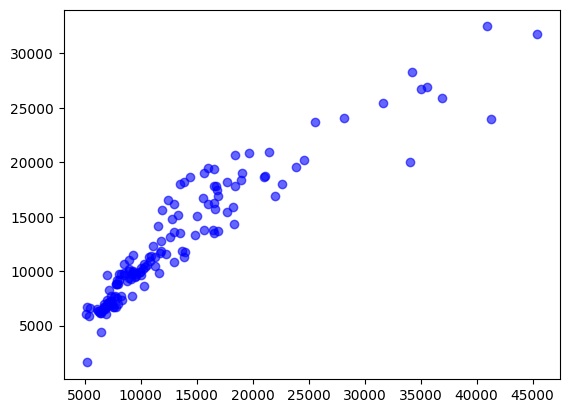

In [ ]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
model = search.best_estimator_
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print("R2:", r2)
plt.scatter(y, y_pred, alpha=0.6, color='b')
plt.show()


# 評估欄位影響度 Permutation Importance

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score


def getFieldImpact(model, x, y, score):
    prediction = model.predict(x)
    full_field_score = score(y, prediction)
    impact = {}
    for column_name in x.columns:
        x2 = x.copy()
        column_data = x2[column_name].to_numpy()
        np.random.shuffle(column_data)
        x2[column_name] = column_data
        p2 = model.predict(x2)
        score2 = score(y, p2)
        impact[column_name] = (full_field_score - score2) / full_field_score
    return impact



impact = getFieldImpact(model, X, y, r2_score)
impact

{'symboling': 0.00036043712649669145,
 'Normalized-losses': 0.0021947883758232935,
 'make_toyota': 0.00029565919628510843,
 'make_mazda': 0.0001399167132606899,
 'make_nissan': 4.3996702520558366e-05,
 'make_subaru': 1.3395459314159875e-05,
 'make_mitsubishi': 5.9287990940386364e-05,
 'make_volkswagen': 3.938548875416545e-05,
 'make_honda': 1.0760823239633822e-05,
 'make_volvo': -1.6086172091868084e-05,
 'make_peugot': 8.869663892074179e-05,
 'make_dodge': 3.875417983899219e-06,
 'make_bmw': 0.004669824388465183,
 'make_mercedes-benz': -3.189677848941039e-05,
 'make_audi': 3.481940093411191e-05,
 'make_plymouth': 4.574249181108608e-08,
 'make_porsche': 0.00032402212137745896,
 'make_saab': 1.1830143241256608e-05,
 'make_chevrolet': -3.0282956625717205e-07,
 'make_alfa-romero': 1.6105875804292027e-06,
 'make_isuzu': -1.8464406687836723e-06,
 'make_renault': 0.0,
 'make_mercury': 0.0,
 'make_jaguar': 4.2111614305191935e-07,
 'Fuel-type_gas': -6.317942409998247e-05,
 'Fuel-type_diesel': 0